In [29]:
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS
import string
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/intent-detection-train.csv')
nlp = spacy.load('fr_core_news_sm')

In [30]:
# Distribution of labels (intents)
pd.DataFrame(df['label'].value_counts()).transpose()

label,out_of_scope,travel_suggestion,carry_on,translate,lost_luggage,book_hotel,flight_status,book_flight,travel_alert
count,21,8,8,7,7,7,6,6,5


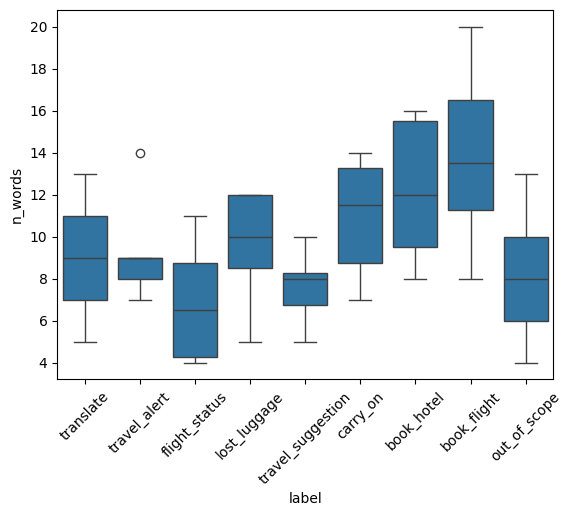

In [31]:
# Distribution of number of words in each sentence per label
df['n_words'] = df['text'].apply(lambda x: len(x.split()))
df.groupby('label')['n_words'].describe().sort_values('mean', ascending=False).transpose()

import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='label', y='n_words', data=df)
plt.xticks(rotation=45)
plt.show()

In [32]:
# Most common words per label
from collections import Counter

def most_common_words_per_label(df):
    most_common_words = {}
    for label in df['label'].unique():
        words = ' '.join(df[df['label'] == label]['text']).split()
        most_common_words[label] = Counter(words).most_common(10)
    return most_common_words

most_common_words = most_common_words_per_label(df)
pd.DataFrame(most_common_words)

,translate,travel_alert,flight_status,lost_luggage,travel_suggestion,carry_on,book_hotel,book_flight,out_of_scope
0,"(en, 6)","(de, 5)","(vol, 5)","(bagages, 6)","(à, 6)","(de, 6)","(à, 7)","(de, 7)","(de, 11)"
1,"(dire, 5)","(voyage, 4)","(Quand, 4)","(mes, 4)","(faire, 3)","(à, 6)","(du, 5)","(à, 5)","(la, 8)"
2,"(comment, 4)","(des, 3)","(mon, 4)","(à, 3)","(des, 2)","(pour, 6)","(au, 5)","(vol, 4)","(est, 7)"
3,"(me, 2)","(alertes, 3)","(à, 3)","(perdus, 2)","(activités, 2)","(main, 5)","(chambre, 3)","(aller-retour, 3)","(le, 7)"
4,"(que, 2)","(pour, 3)","(Y, 1)","(Flight, 2)","(touristiques, 2)","(les, 4)","(un, 3)","(un, 3)","(Combien, 5)"
5,"(Comment, 2)","(Y, 2)","(a-t-il, 1)","(America, 2)","(amusantes, 2)","(bagage, 3)","(lundi, 3)","(vols, 2)","(plus, 4)"
6,"(Pouvez-vous, 1)","(a-t-il, 2)","(des, 1)","(Airlines, 2)","(de, 2)","(Airlines, 3)","(une, 2)","(Je, 2)","(des, 3)"
7,"(«je, 1)","(la, 2)","(nouvelles, 1)","(O'Hare, 2)","(la, 2)","(cabine, 3)","(11, 2)","(du, 2)","(Quelle, 3)"
8,"(ne, 1)","(La, 1)","(sur, 1)","(sur, 2)","(Veuillez, 1)","(bagages, 3)","(15, 2)","(février, 2)","(Quel, 3)"
9,"(parle, 1)","(Corée, 1)","(le, 1)","(que, 2)","(suggérer, 1)","(American, 2)","(novembre, 2)","(au, 2)","(à, 3)"


In [33]:
# Import the stop words list from spacy and remove some words
TO_KEEP = ['dire', 'comment']
STOP_WORDS = [word for word in STOP_WORDS if word not in TO_KEEP]

def preprocess_text(text: str):
    text = text.strip().lower()
    text = text.translate(str.maketrans('', '', string.punctuation + '«»“”'))
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text and not token.is_punct and token.lemma_ not in STOP_WORDS]
    
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)

# Save the preprocessed data 
df.to_csv('../data/preprocessed_dataset.csv', index=False)
df.head()

,text,label,n_words,clean_text
0,Pouvez-vous me dire comment dire «je ne parle ...,translate,13,pouvezvous dire comment dire beaucoup espagnol...
1,Dites-moi comment dire: «C'est une belle matin...,translate,9,ditesmoi comment dire cest bel matiner italien
2,"Si j'étais japonais, comment dirais-je que je ...",translate,9,jétai japonais comment diraisje tourist
3,Comment dire «hôtel» en finnois,translate,5,comment dire hôtel finnois
4,"J'ai besoin que vous traduisiez la phrase, «no...",translate,13,jai besoin traduire phrase seron bientôt portuger


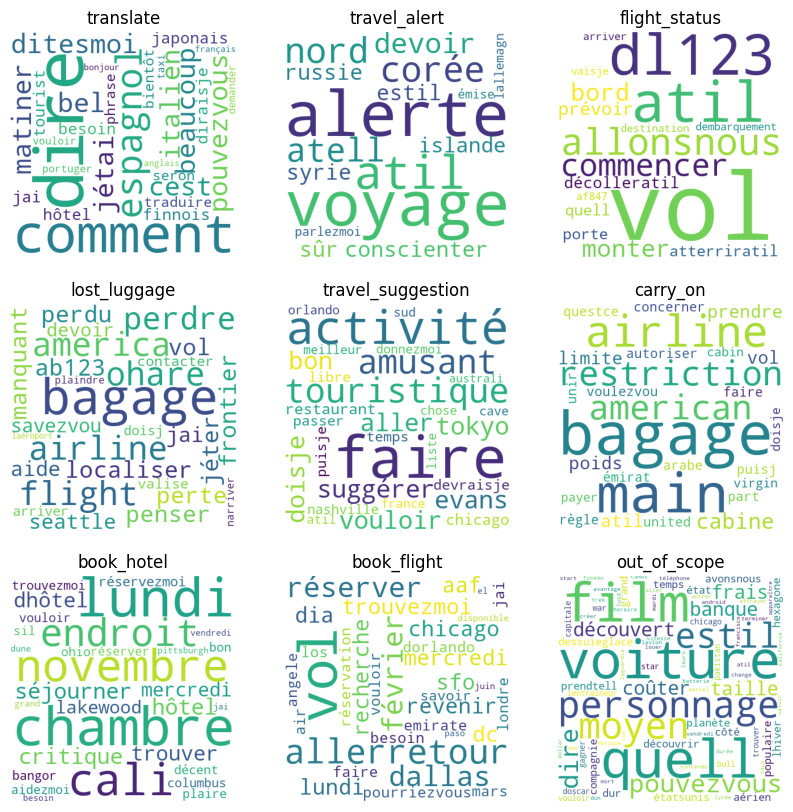

In [34]:
from wordcloud import WordCloud

# Plot all 9 word clouds in a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, label in enumerate(df['label'].unique()):
    words = ' '.join(df[df['label'] == label]['clean_text'])
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate(words)
    axs[i//3, i%3].imshow(wordcloud)
    axs[i//3, i%3].set_title(label)
    axs[i//3, i%3].axis('off')

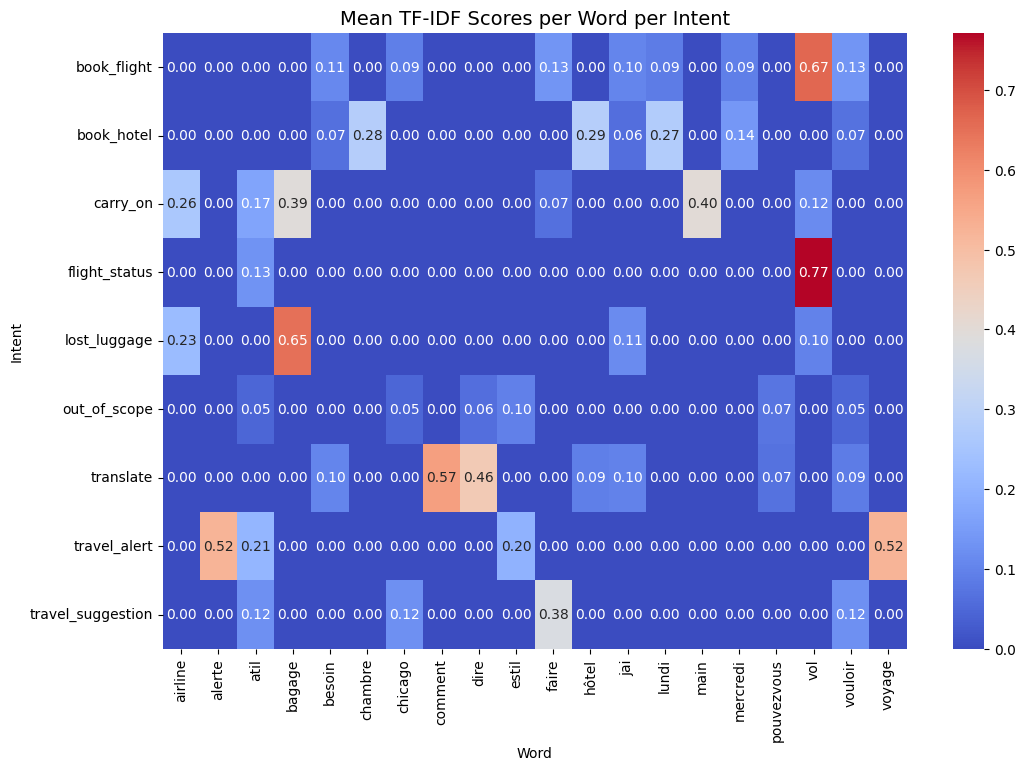

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=20)  # Adjust 'max_features' as needed

# Fit and transform the preprocessed text
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Add the labels to the DataFrame
tfidf_df['label'] = df['label']

# Compute the mean TF-IDF score per word per class
mean_tfidf = tfidf_df.groupby('label').mean()

# Plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mean_tfidf, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mean TF-IDF Scores per Word per Intent', fontsize=14)
plt.xlabel('Word')
plt.ylabel('Intent')
plt.show()

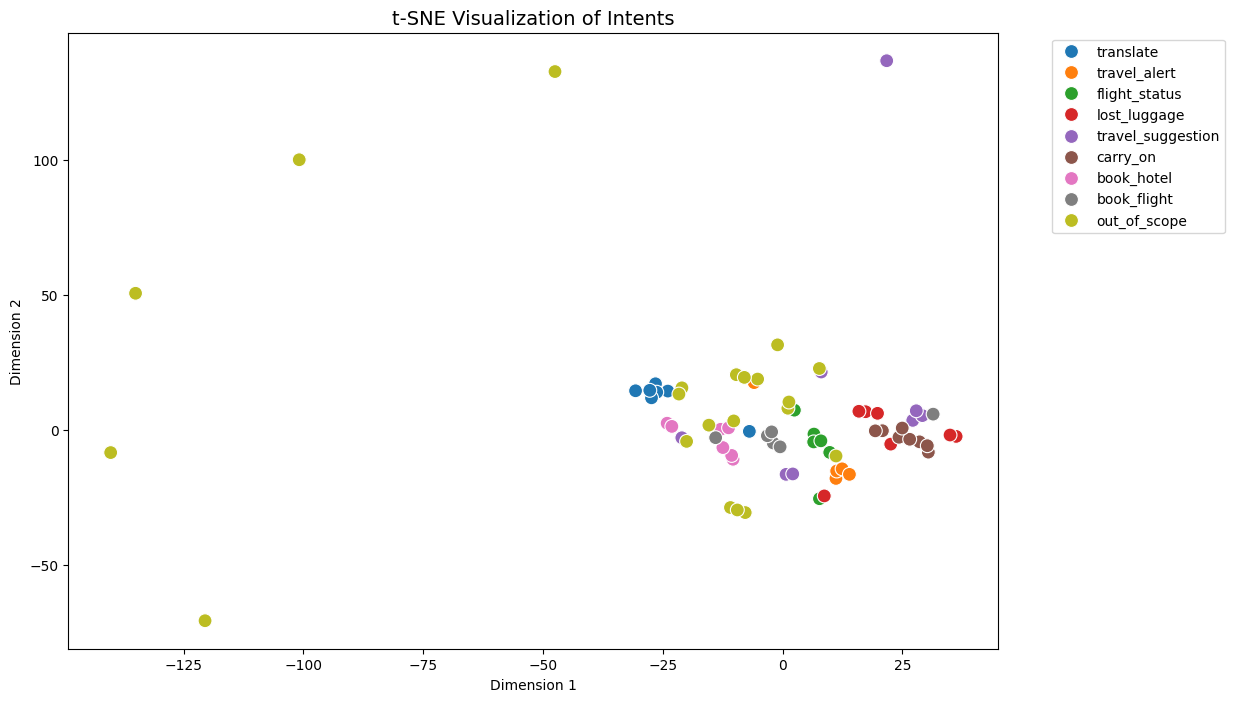

In [36]:
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Use TF-IDF to vectorize the preprocessed text
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
tsne_results = tsne.fit_transform(tfidf_matrix.toarray())

# Create a DataFrame with t-SNE results
tsne_df = pd.DataFrame({
    'tsne1': tsne_results[:,0],
    'tsne2': tsne_results[:,1],
    'label': df['label']
})

# Plot the t-SNE results
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne1', y='tsne2',
    hue='label',
    palette='tab10',
    data=tsne_df,
    legend='full',
    s=100
)
plt.title('t-SNE Visualization of Intents', fontsize=14)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

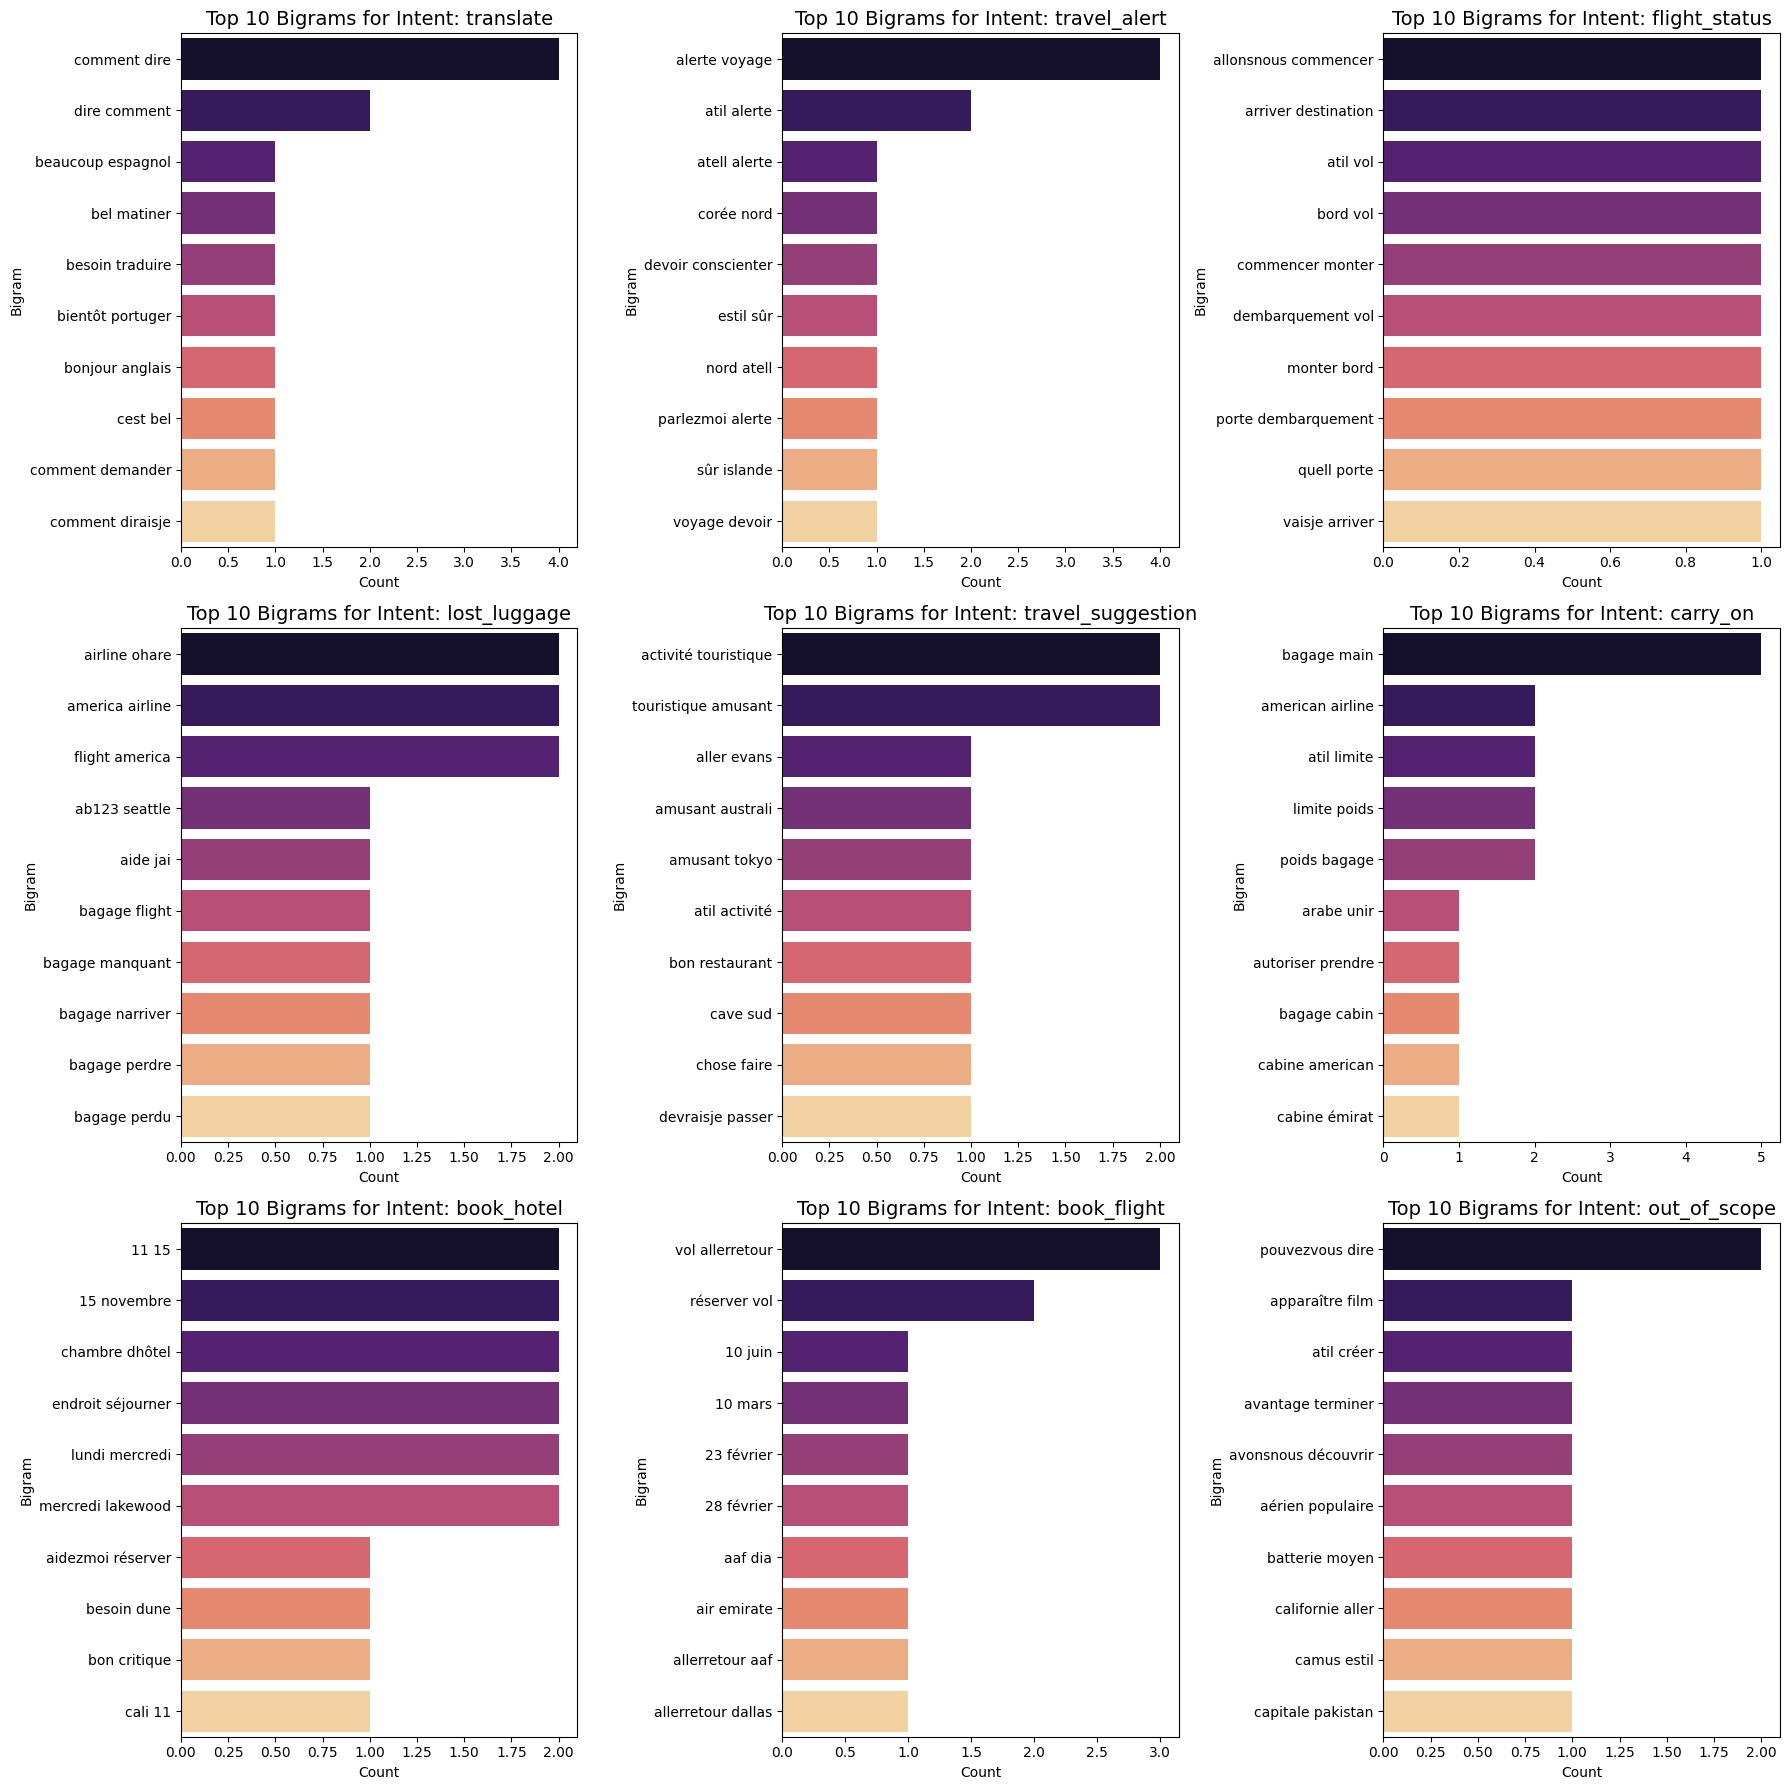

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_bigrams(df, class_label=None, top_n=10, ax=None):
    if class_label:
        texts = df[df['label'] == class_label]['clean_text']
        title = f'Top {top_n} Bigrams for Intent: {class_label}'
    else:
        texts = df['clean_text']
        title = f'Top {top_n} Bigrams Across All Intents'
    
    # Create a CountVectorizer for bigrams
    vectorizer = CountVectorizer(ngram_range=(2,2))
    X = vectorizer.fit_transform(texts)
    
    # Sum up the counts of each bigram
    counts = X.sum(axis=0).A1
    bigrams = vectorizer.get_feature_names_out()
    bigram_counts = list(zip(bigrams, counts))
    
    # Sort bigrams by frequency
    bigram_counts = sorted(bigram_counts, key=lambda x: x[1], reverse=True)[:top_n]
    
    # Create DataFrame for plotting
    bigrams_df = pd.DataFrame(bigram_counts, columns=['bigram', 'count'])
    
    # Plot
    sns.barplot(x='count', y='bigram', data=bigrams_df, palette='magma', ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Count')
    ax.set_ylabel('Bigram')

# Plot top bigrams across all intents
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

# Plot top bigrams for each intent
for i, class_label in enumerate(df['label'].unique()):
    plot_top_bigrams(df, class_label=class_label, top_n=10, ax=axes[i])

plt.tight_layout()